In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats
from math import sin, cos, sqrt, atan2, radians
import osrm
import pyproj
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 5000)

In [2]:
# Read in taxi data
org_path = os.getcwd()
taxi_path = org_path + '\\Taxi_Data\\'
notebook_path = org_path + '\\Notebook_Data\\'

save_path = org_path + '\\Notebook_Data\\'

df = pd.read_csv(taxi_path + 'train.csv', float_precision='round_trip')

In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
# Fix the format on the date columns
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], infer_datetime_format = True)
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], infer_datetime_format = True)

# Drop the dropoff time right from the start to avoid using any information from that for feature engineering
df = df.drop(columns = 'dropoff_datetime')

# Initial Feature Engineering

In [5]:
# Get the month, day, day of the week and hour for every trip
df['month'] = df['pickup_datetime'].dt.month
df['day_of_month'] = df['pickup_datetime'].dt.day
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour_of_day'] = df['pickup_datetime'].dt.hour

In [6]:
# Create a binary variable that states if the trip is on a weekend
df['is_weekend'] = pd.Series(np.where(df['day_of_week'].values >= 5, 1, 0),
                             df.index)

In [7]:
# Get the Haversine distance and bearing for every trip
distance_list = list()
heading_list = list()

# This done using the pyproj library
geodesic = pyproj.Geod(ellps='WGS84')

# Initalise the new columns
df['trip_distance'] = np.nan
df['trip_heading'] = np.nan

# Loop over every row and extract the distance and heading based on the pickup and dropoff coordinates
for row in tqdm(df.itertuples()):
    heading, inverse_heading, distance = geodesic.inv(lats1 = row.pickup_latitude, lons1 = row.pickup_longitude,
                                                      lats2 = row.dropoff_latitude, lons2 = row.dropoff_longitude)
    
    # Add these values to the corrisponding column
    df.at[row.Index, 'trip_distance'] = distance
    df.at[row.Index, 'trip_heading'] = heading

### Adding features from seperate files

Some geocoding was done in a seperate file, refer to "geocoding" notebook for more information. The information from that file is mostly related to what borough the trip took place, but also if the trips took place near the local airports.

In [8]:
location_info = pd.read_csv(notebook_path + 'geocode_info_mapping_with_pol.csv')

In [9]:
location_info.head()

,id,longitude,latitude,is_pickup,lat,lon,name,admin1,admin2,cc,borough,airport,detailed_borough
0,id2875421,-73.982155,40.767937,1,40.78343,-73.96625,Manhattan,New York,New York County,US,Manhattan,NaN,Midtown Manhattan
1,id2377394,-73.980415,40.738564,1,40.74482,-73.94875,Long Island City,New York,Queens County,US,Manhattan,NaN,Midtown Manhattan
2,id3858529,-73.979027,40.763939,1,40.78343,-73.96625,Manhattan,New York,New York County,US,Manhattan,NaN,Midtown Manhattan
3,id3504673,-74.010040,40.719971,1,40.71427,-74.00597,New York City,New York,NaN,US,Manhattan,NaN,Lower Manhattan
4,id2181028,-73.973053,40.793209,1,40.78343,-73.96625,Manhattan,New York,New York County,US,Manhattan,NaN,Upper Manhattan


In [10]:
# Some wrangling is needed to combine this new dataframe with the existing one
# Mainly to combine the pickup and dropoff information of each trip into the same row
pickup_locations = location_info[location_info['is_pickup'] == 1][['id', 'admin1', 'detailed_borough', 'airport']]
dropoff_locations = location_info[location_info['is_pickup'] == 0][['id', 'admin1', 'detailed_borough', 'airport']]

# Rename columns to avoid duplicate column names
pickup_locations.columns = ['id', 'pickup_admin1', 'pickup_borough', 'pickup_airport']
dropoff_locations.columns = ['id', 'dropoff_admin1', 'dropoff_borough', 'dropoff_airport']

# Merge with master dataframe based on the trip ID
df = pd.merge(df, pickup_locations, on = 'id')
df = pd.merge(df, dropoff_locations, on = 'id')

In [11]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_month,day_of_week,hour_of_day,is_weekend,trip_distance,trip_heading,pickup_admin1,pickup_borough,pickup_airport,dropoff_admin1,dropoff_borough,dropoff_airport
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,0,17,0,1502.171837,99.932546,New York,Midtown Manhattan,NaN,New York,Upper Manhattan,NaN
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,6,0,1,1808.659969,-117.063997,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,1,11,0,6379.687175,-159.608029,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,2,19,0,1483.632481,-172.709884,New York,Lower Manhattan,NaN,New York,Lower Manhattan,NaN
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,5,13,1,1187.037659,179.471551,New York,Upper Manhattan,NaN,New York,Upper Manhattan,NaN


To extract more accurate distance number, an external API called open source routing machine (OSRM) was used to get recommended routing information for each trip. That is the only new information added from this dataframe but was kept in a seperate notebook for convenient running. Refer to the "OSRM_routing" notebook for more information on the code.

In [12]:
routing_info = pd.read_csv(notebook_path + 'routing_df.csv')

In [13]:
routing_info.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,route_distance
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2008.4
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2515.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11061.2
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,1819.4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,1610.7


In [14]:
# Merge this new dataframe with the master dataframe
df = pd.merge(df, routing_info[['id', 'route_distance']], on = 'id')

In [15]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_month,day_of_week,hour_of_day,is_weekend,trip_distance,trip_heading,pickup_admin1,pickup_borough,pickup_airport,dropoff_admin1,dropoff_borough,dropoff_airport,route_distance
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,0,17,0,1502.171837,99.932546,New York,Midtown Manhattan,NaN,New York,Upper Manhattan,NaN,2008.4
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,6,0,1,1808.659969,-117.063997,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,2515.0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,1,11,0,6379.687175,-159.608029,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,11061.2
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,2,19,0,1483.632481,-172.709884,New York,Lower Manhattan,NaN,New York,Lower Manhattan,NaN,1819.4
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,5,13,1,1187.037659,179.471551,New York,Upper Manhattan,NaN,New York,Upper Manhattan,NaN,1610.7


# Data Cleaning
There were some outliers that were clear when observing the data. Some trips took place in California, some trips had pickups in the middle of the ocean and some trips lasted for almost a full day. The following commands clean up this messy data.

In [16]:
# Remove all trips that do not have at least a dropoff or a pickup in the states of New York and New Jersey
df = df[(df['pickup_admin1'] == 'New York') | (df['pickup_admin1'] == 'New Jersey') | 
               (df['dropoff_admin1'] == 'New York') | (df['dropoff_admin1'] == 'New Jersey')]

In [17]:
# Remove trips that belong to the so called "Z Junk" borough. 
# This borough was created to clean out the points originating in the ocean, see "geocoding" for more information
df = df[(df['pickup_borough'] != 'Z Junk') & (df['dropoff_borough'] != 'Z Junk')]

In [18]:
# Remove all trips that are more then 3 standard deviations from the mean, this is a popular method to remove outliers
df = df[(np.abs(stats.zscore(df['trip_duration'])) <= 3)]

In [19]:
# Remove trips that did not travel any distance
df = df[df['trip_distance'] != 0]

# Further Feature Engineering

Based on some answers online, the rush hour in New York was said to be split in two. The morning rush between 7:00 and 10:00 and the evening rush between 15:00 and 19:00. However, this had to be investigated first.

In [20]:
# Create a temporary copy of the master dataframe to avoid making changes to it
temp_df = df.copy()
# Get the average speed for each trip
temp_df['average_speed'] = temp_df['route_distance'] / temp_df['trip_duration']


# Set a maximum average speed of 25 meters per second, everything outside of that is a clear outlier
maximum_speed = 25
# Print the number of trips over and under the limit, this helps with visualising how much data is dumped
print('Number of trips with average under {} kilometers per hour: {}'
      .format(maximum_speed * 3.6, len(temp_df[temp_df['average_speed'] <= maximum_speed]))) 
print('Number of trips with average over {} kilometers per hour: {}'
      .format(maximum_speed * 3.6, len(temp_df[temp_df['average_speed'] > maximum_speed]))) 

# Filter based on the above condition to create a new speed dataframe
speed_df = temp_df[temp_df['average_speed'] <= maximum_speed]

Number of trips with average under 90.0 kilometers per hour: 1421582
Number of trips with average over 90.0 kilometers per hour: 1745


In [21]:
# Use the average speed value to find average speed based on hour of the day
hourly_speed = speed_df.groupby('hour_of_day')['average_speed'].mean()

With this information, the hourly speed can be plotted to view the real effects of rush hour on trafic speed

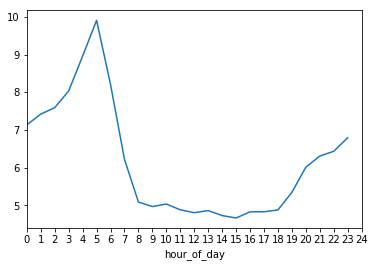

In [22]:
hourly_speed.plot.line()
plt.xticks(np.arange(0, 25, 1.0))
plt.show()

It is safe to say that the rush hour begins around 7:00 in the morning and does not stop until after work around 19:00. Therefore, we can generate a new column to indicate if the trip is during rush hour or not

In [23]:
df['is_rushhour'] = pd.Series(np.where(df['hour_of_day'].between(7, 18), 1, 0),
                              df.index)

In [24]:
# Create a variable that checks if pickup and dropoff was in the same area
df['same_area'] = pd.Series(np.where(df['pickup_borough'] == df['dropoff_borough'], 1, 0), 
                            df.index)

In [25]:
df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_month,day_of_week,hour_of_day,is_weekend,trip_distance,trip_heading,pickup_admin1,pickup_borough,pickup_airport,dropoff_admin1,dropoff_borough,dropoff_airport,route_distance,is_rushhour,same_area
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,0,17,0,1502.171837,99.932546,New York,Midtown Manhattan,NaN,New York,Upper Manhattan,NaN,2008.4,1,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,6,0,1,1808.659969,-117.063997,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,2515.0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,1,11,0,6379.687175,-159.608029,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,11061.2,1,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,2,19,0,1483.632481,-172.709884,New York,Lower Manhattan,NaN,New York,Lower Manhattan,NaN,1819.4,0,1
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,5,13,1,1187.037659,179.471551,New York,Upper Manhattan,NaN,New York,Upper Manhattan,NaN,1610.7,1,1


Create the dummy variables for all the categorical variables, this is needed for the models who will be later implemented. The reasoning behind this is that the main models who will later be used can easily deal with noise. Therefore, the days and passenger information is kept as categorical variables. This results in a very high dimensional model, but the model might pick up on some valuable patters. For example, multiple passenger might mean that there are multiple dropoffs and a longer trip time.

In [26]:
dummy_vendor = pd.get_dummies(df['vendor_id'], prefix = 'vendorid', prefix_sep = '_')
dummy_passenger_count = pd.get_dummies(df['passenger_count'], prefix = 'passengercount', prefix_sep = '_')
dummy_store_and_fwd_flag = pd.get_dummies(df['store_and_fwd_flag'], prefix = 'storeandforward', prefix_sep = '_')

dummy_pickup_borough = pd.get_dummies(df['pickup_borough'], prefix = 'pickupborough', prefix_sep = '_')
dummy_dropoff_borough = pd.get_dummies(df['dropoff_borough'], prefix = 'dropoffborough', prefix_sep = '_')

dummy_month = pd.get_dummies(df['month'], prefix = 'month', prefix_sep = '_')
dummy_day_of_month = pd.get_dummies(df['day_of_month'], prefix = 'dayofmonth', prefix_sep = '_')
dummy_day_of_week = pd.get_dummies(df['day_of_week'], prefix = 'dayofweek', prefix_sep = '_')
dummy_hour_of_day = pd.get_dummies(df['hour_of_day'], prefix = 'hour', prefix_sep = '_')

dummy_pickup_airport = pd.get_dummies(df['pickup_airport'], prefix = 'pickupairport', prefix_sep = '_')
dummy_dropoff_airport = pd.get_dummies(df['dropoff_airport'], prefix = 'dropoffairport', prefix_sep = '_')

In [27]:
# Combine into a single dataframe
final_df = pd.concat([df, dummy_vendor, dummy_passenger_count, dummy_store_and_fwd_flag, dummy_pickup_borough, 
                     dummy_dropoff_borough, dummy_month, dummy_day_of_month, dummy_day_of_week, dummy_hour_of_day, 
                     dummy_pickup_airport, dummy_dropoff_airport], axis = 1)

In [28]:
final_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,day_of_month,day_of_week,hour_of_day,is_weekend,trip_distance,trip_heading,pickup_admin1,pickup_borough,pickup_airport,dropoff_admin1,dropoff_borough,dropoff_airport,route_distance,is_rushhour,same_area,vendorid_1,vendorid_2,passengercount_0,passengercount_1,passengercount_2,passengercount_3,passengercount_4,passengercount_5,passengercount_6,passengercount_7,passengercount_8,storeandforward_N,storeandforward_Y,pickupborough_Bronx,pickupborough_Brooklyn,pickupborough_Lower Manhattan,pickupborough_Midtown Manhattan,pickupborough_New Jersey,pickupborough_Queens,pickupborough_Staten Island,pickupborough_Upper Manhattan,pickupborough_Well Outside NYC,dropoffborough_Bronx,dropoffborough_Brooklyn,dropoffborough_Lower Manhattan,dropoffborough_Midtown Manhattan,dropoffborough_New Jersey,dropoffborough_Queens,dropoffborough_Staten Island,dropoffborough_Upper Manhattan,dropoffborough_Well Outside NYC,month_1,month_2,month_3,month_4,month_5,month_6,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,dayofmonth_6,dayofmonth_7,dayofmonth_8,dayofmonth_9,dayofmonth_10,dayofmonth_11,dayofmonth_12,dayofmonth_13,dayofmonth_14,dayofmonth_15,dayofmonth_16,dayofmonth_17,dayofmonth_18,dayofmonth_19,dayofmonth_20,dayofmonth_21,dayofmonth_22,dayofmonth_23,dayofmonth_24,dayofmonth_25,dayofmonth_26,dayofmonth_27,dayofmonth_28,dayofmonth_29,dayofmonth_30,dayofmonth_31,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,pickupairport_JFK Airport,pickupairport_LaGuardia Airport,pickupairport_Newark Liberty Airport,dropoffairport_JFK Airport,dropoffairport_LaGuardia Airport,dropoffairport_Newark Liberty Airport
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,0,17,0,1502.171837,99.932546,New York,Midtown Manhattan,NaN,New York,Upper Manhattan,NaN,2008.4,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,6,0,1,1808.659969,-117.063997,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,2515.0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,1,11,0,6379.687175,-159.608029,New York,Midtown Manhattan,NaN,New York,Lower Manhattan,NaN,11061.2,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,2,19,0,1483.632481,-172.709884,New York,Lower Manhattan,NaN,New York,Lower Manhattan,NaN,1819.4,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,5,13,1,1187.037659,179.471551,New York,Upper Manhattan,NaN,New York,Upper Manhattan,NaN,1610.7,1,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# Drop all categorical variables
final_df_drop = final_df.drop(['id', 'vendor_id', 'pickup_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 
                        'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_borough', 'dropoff_borough',
                        'month','day_of_month','day_of_week','hour_of_day', 'pickup_admin1', 'dropoff_admin1', 
                        'pickup_airport', 'dropoff_airport']
                       ,axis = 1)

In [30]:
# Save a file containing all features
final_df.to_csv(save_path + 'cleaned_data_nodrop.csv', index = False)

In [31]:
# Save a file that does not contain the categorical variables
final_df_drop.to_csv(save_path + 'cleaned_data_drop.csv', index = False)